In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_parquet('zra_4_150_40_ts.parquet')
df

,sintez_group,posting_date,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,out_bmu_sum,stock_sum
0,ЗРА_4_150_40,2017-01-01,0,0.0,0,0.0,507.0
1,ЗРА_4_150_40,2017-01-02,0,0.0,0,0.0,507.0
2,ЗРА_4_150_40,2017-01-03,0,0.0,0,0.0,507.0
3,ЗРА_4_150_40,2017-01-04,0,0.0,0,0.0,505.0
4,ЗРА_4_150_40,2017-01-05,0,0.0,0,0.0,505.0
...,...,...,...,...,...,...,...
2029,ЗРА_4_150_40,2022-07-23,0,0.0,0,0.0,485.0
2030,ЗРА_4_150_40,2022-07-24,0,0.0,0,0.0,485.0
2031,ЗРА_4_150_40,2022-07-25,0,0.0,0,0.0,485.0
2032,ЗРА_4_150_40,2022-07-26,0,0.0,0,0.0,485.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2034 entries, 0 to 2033
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sintez_group        2034 non-null   object 
 1   posting_date        2034 non-null   object 
 2   inc_bmu_fact_count  2034 non-null   int64  
 3   inc_bmu_sum         2034 non-null   float64
 4   out_bmu_fact_count  2034 non-null   int64  
 5   out_bmu_sum         2034 non-null   float64
 6   stock_sum           2034 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 127.1+ KB


In [ ]:
df['sintez_group'].value_counts()

ЗРА_4_150_40    2034
Name: sintez_group, dtype: int64

In [ ]:
cut_date = lambda x: x[:7]
df['cut_date'] = df['posting_date'].apply(cut_date)
df

,sintez_group,posting_date,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,out_bmu_sum,stock_sum,cut_date
0,ЗРА_4_150_40,2017-01-01,0,0.0,0,0.0,507.0,2017-01
1,ЗРА_4_150_40,2017-01-02,0,0.0,0,0.0,507.0,2017-01
2,ЗРА_4_150_40,2017-01-03,0,0.0,0,0.0,507.0,2017-01
3,ЗРА_4_150_40,2017-01-04,0,0.0,0,0.0,505.0,2017-01
4,ЗРА_4_150_40,2017-01-05,0,0.0,0,0.0,505.0,2017-01
...,...,...,...,...,...,...,...,...
2029,ЗРА_4_150_40,2022-07-23,0,0.0,0,0.0,485.0,2022-07
2030,ЗРА_4_150_40,2022-07-24,0,0.0,0,0.0,485.0,2022-07
2031,ЗРА_4_150_40,2022-07-25,0,0.0,0,0.0,485.0,2022-07
2032,ЗРА_4_150_40,2022-07-26,0,0.0,0,0.0,485.0,2022-07


In [ ]:
df['posting_date'] = pd.to_datetime(df.posting_date)

In [ ]:
df.set_index('posting_date', inplace = True)
df.drop(['sintez_group','inc_bmu_fact_count','inc_bmu_sum','stock_sum','out_bmu_fact_count'],axis=1,inplace=True)
df

,out_bmu_sum
posting_date,
2017-01-01,0.0
2017-01-02,0.0
2017-01-03,0.0
2017-01-04,0.0
2017-01-05,0.0
...,...
2022-07-23,0.0
2022-07-24,0.0
2022-07-25,0.0


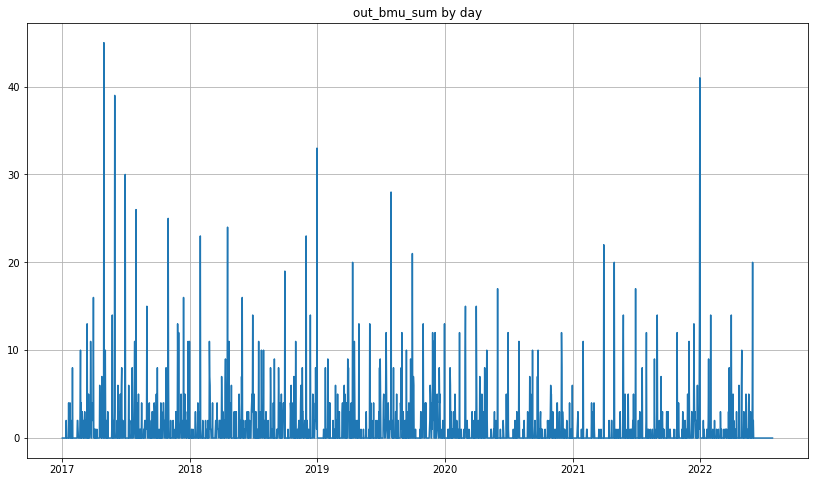

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,8))

plt.title('out_bmu_sum by day')
plt.plot(df.posting_date,df.out_bmu_sum)
plt.grid()

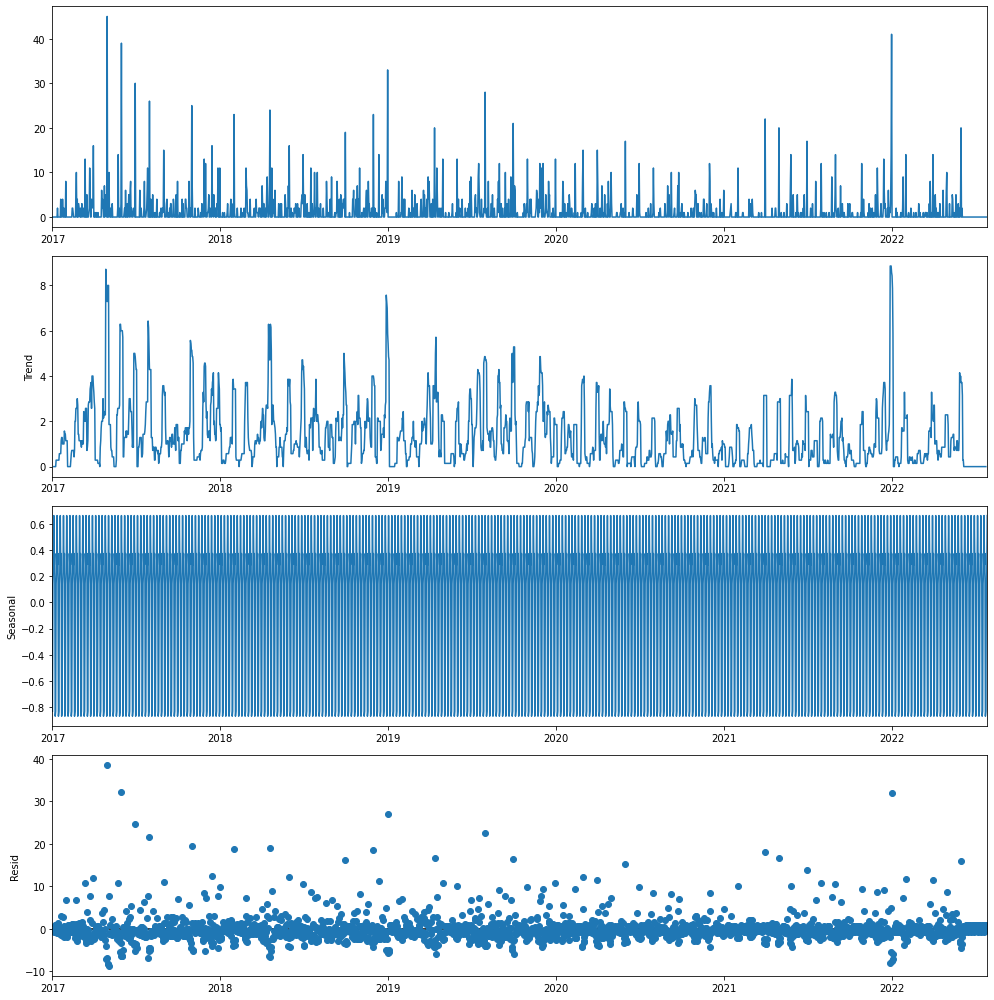

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams
rcParams['figure.figsize'] = 14, 14

decompose = seasonal_decompose(df)
decompose.plot()
 
plt.show()

In [ ]:
df[['posting_date','out_bmu_sum']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2034 entries, 0 to 2033
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   posting_date  2034 non-null   datetime64[ns]
 1   out_bmu_sum   2034 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 112.2 KB


In [ ]:
df_months = df.groupby('cut_date',as_index=False).aggregate({'out_bmu_sum':'sum'})
df_months

,cut_date,out_bmu_sum
0,2017-01,21.0
1,2017-02,28.0
2,2017-03,76.0
3,2017-04,78.0
4,2017-05,76.0
...,...,...
62,2022-03,33.0
63,2022-04,34.0
64,2022-05,47.0
65,2022-06,2.0


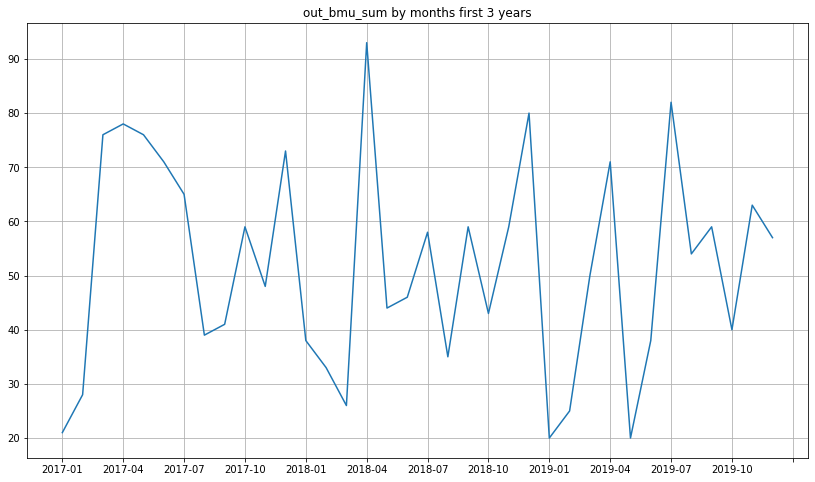

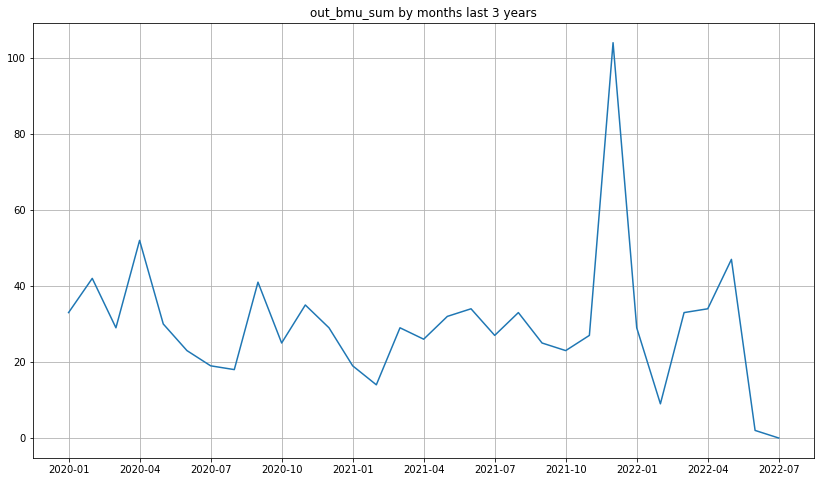

In [ ]:
from matplotlib.pyplot import MultipleLocator


df_months_first_3_years = df_months[:36]
df_months_last_3_years = df_months[36:]

plt.figure(figsize=(14,8))
plt.title('out_bmu_sum by months first 3 years')
plt.plot(df_months_first_3_years.cut_date,df_months_first_3_years.out_bmu_sum)
plt.grid()

ax=plt.gca()
x_major_locator=MultipleLocator(3)
ax.xaxis.set_major_locator(x_major_locator)

plt.figure(figsize=(14,8))
plt.title('out_bmu_sum by months last 3 years')
plt.plot(df_months_last_3_years.cut_date,df_months_last_3_years.out_bmu_sum)
plt.grid()

ax=plt.gca()
x_major_locator=MultipleLocator(3)
ax.xaxis.set_major_locator(x_major_locator)

In [ ]:
df_months_3_years

,cut_date,out_bmu_sum
0,2017-01,21.0
1,2017-02,28.0
2,2017-03,76.0
3,2017-04,78.0
4,2017-05,76.0
5,2017-06,71.0
6,2017-07,65.0
7,2017-08,39.0
8,2017-09,41.0
9,2017-10,59.0


In [ ]:
df_months

,cut_date,out_bmu_sum
0,2017-01,21.0
1,2017-02,28.0
2,2017-03,76.0
3,2017-04,78.0
4,2017-05,76.0
...,...,...
62,2022-03,33.0
63,2022-04,34.0
64,2022-05,47.0
65,2022-06,2.0
